In [1]:
# import: external libraries
import torch
import torchshow as ts
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from pathlib import Path

print(f"cuda: {torch.cuda.is_available()}")

# import: solutions from the lessons
from underwater_imagery.models.model import Encoder, Decoder, EncoderDecoder, VGGEncoder

# import: own modules
from underwater_imagery.uim_dataset import UIMDataset

cuda: True


In [2]:
path = Path("./data/train_val/")
classes = [
    ('BW', torch.tensor([0, 0, 0], dtype=torch.uint8)),
    ('HD', torch.tensor([0, 0, 1], dtype=torch.uint8)),
    ('PF', torch.tensor([0, 1, 0], dtype=torch.uint8)),
    ('WR', torch.tensor([0, 1, 1], dtype=torch.uint8)),
    ('RO', torch.tensor([1, 0, 0], dtype=torch.uint8)),
    ('RI', torch.tensor([1, 0, 1], dtype=torch.uint8)),
    ('FV', torch.tensor([1, 1, 0], dtype=torch.uint8)),
    ('SR', torch.tensor([1, 1, 1], dtype=torch.uint8))
]

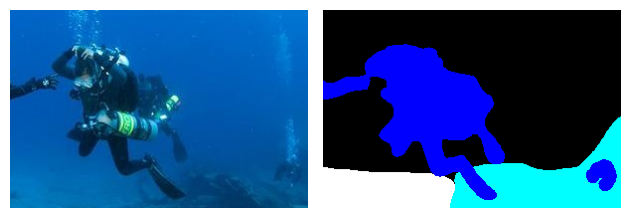

BW


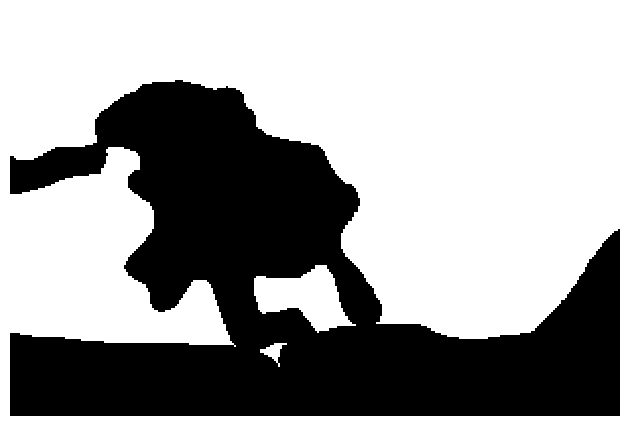

HD


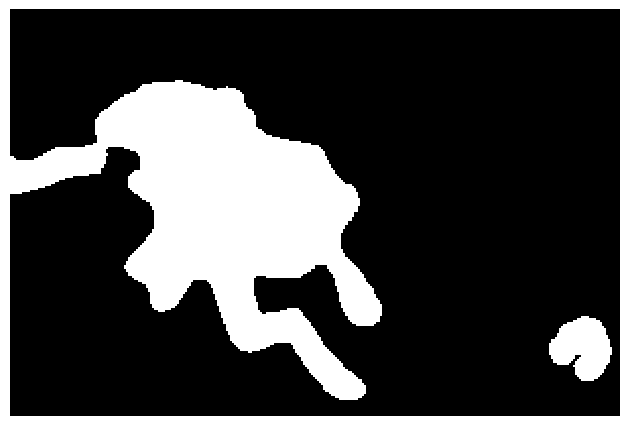

PF


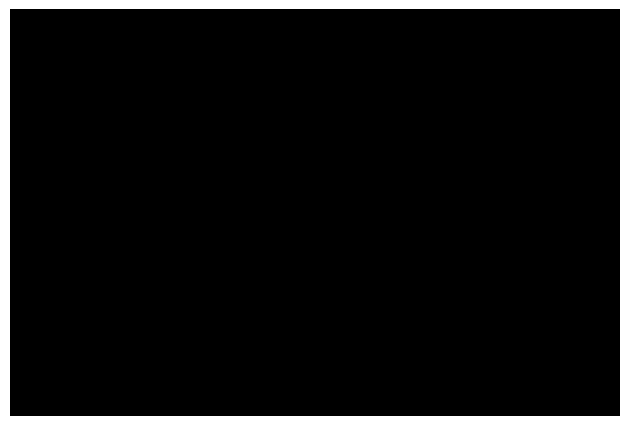

WR


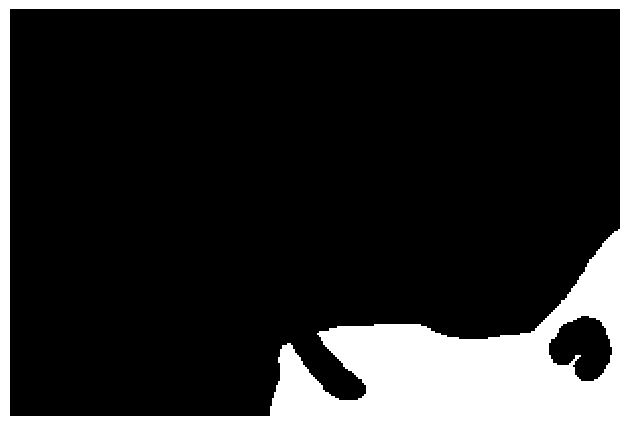

RO


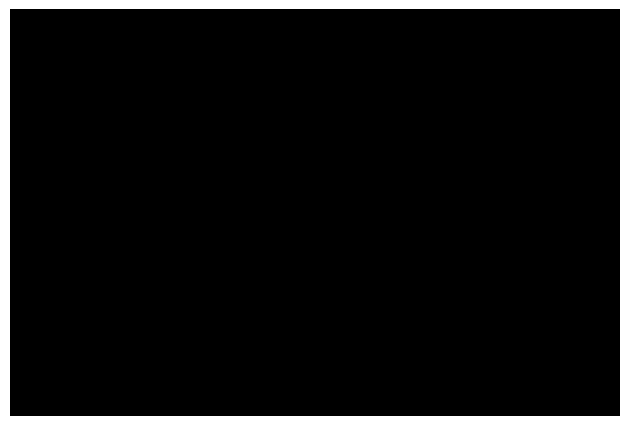

RI


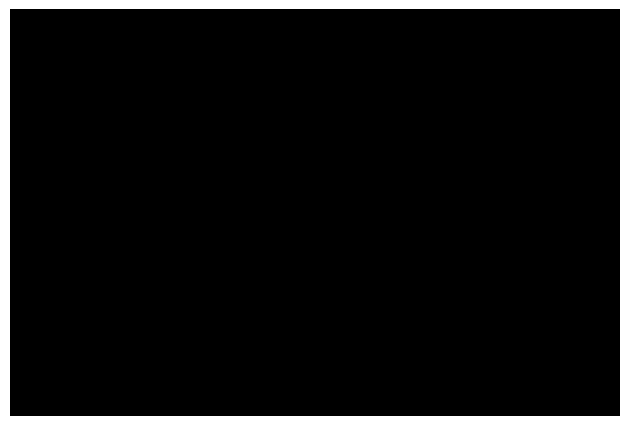

FV


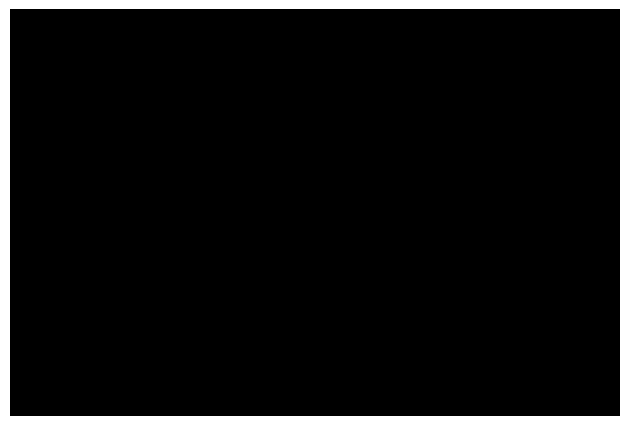

SR


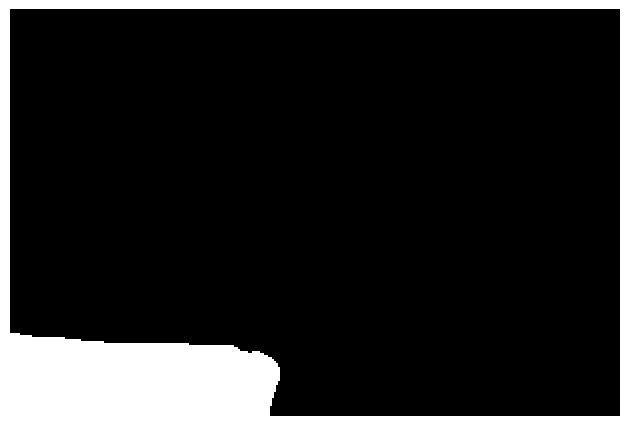

In [3]:
data = UIMDataset(path, classes)
img, mask, label = data[0]
ts.show([img, label])
plt.show()

for i, cls in enumerate(data.classes):
    print(cls[0])
    ts.show(mask[i, :, :]) 
    plt.show()

In [10]:
import torch.optim as optim

torch.manual_seed(123)
num_epochs = 8
batch_size = 16
path = Path("./data/train_val/")

# Define transformations
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 300), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(torch.float),
])

transf_labels = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 300), antialias=True),
    transforms.ConvertImageDtype(torch.float),
])

classes = [
    ('BW', torch.tensor([0, 0, 0], dtype=torch.uint8)),
    ('HD', torch.tensor([0, 0, 1], dtype=torch.uint8)),
    ('PF', torch.tensor([0, 1, 0], dtype=torch.uint8)),
    ('WR', torch.tensor([0, 1, 1], dtype=torch.uint8)),
    ('RO', torch.tensor([1, 0, 0], dtype=torch.uint8)),
    ('RI', torch.tensor([1, 0, 1], dtype=torch.uint8)),
    ('FV', torch.tensor([1, 1, 0], dtype=torch.uint8)),
    ('SR', torch.tensor([1, 1, 1], dtype=torch.uint8))
]

# Dataset and DataLoader initialization
ds = UIMDataset(path, classes, transform=transf, transform_labels=transf_labels)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Model initialization
cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']  # VGG16 simplified configuration
features = VGGEncoder.make_layers(cfg, batch_norm=True)
encoder = VGGEncoder(features)
decoder_channels = [512, 256, 128, 64] 
num_classes = len(classes)

model = EncoderDecoder(encoder, Decoder(decoder_channels), cfg[0], cfg[-2], num_classes).to('cuda')

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for epoch in range(num_epochs):
    for images, masks, _ in dataloader:
        images, masks = images.to('cuda'), masks.to('cuda')
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {loss.item()}')

print('Training completed.')

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[16, 64, 200, 300] to have 3 channels, but got 64 channels instead